In [14]:
import pandas as pd

# ========== 1. 读取数据 ==========
df = pd.read_csv("data/Camden_data.csv")

# ========== 2. 数据筛选 ==========
filtered_df = df[
    (df['property_type'].str.lower() == 'flat') &
    (df['ward22nm'] == 'Bloomsbury') &
    (df['built_form'].str.lower().str.contains('-terrace')) &
    (df['wall_type'].str.lower() != 'other')
].copy()

In [15]:
print(filtered_df.head())

         uprn      os_topo_toid    easting   northing postcode_locator  \
6413  5006230 1000000000000.000 530203.000 181732.000         WC1B 5BH   
6414  5171576 1000000000000.000 530309.000 181747.000         WC1A 2NS   
6417  5136568 1000000000000.000 530334.000 181768.000         WC1A 2QN   
6418  5006231 1000000000000.000 530203.000 181732.000         WC1B 5BH   
6423  5171575 1000000000000.000 530309.000 181747.000         WC1A 2NS   

     administrative_area     oa21cd   lsoa21cd     lsoa21nm   lsoa11cd  ...  \
6413              Camden  E00004169  E01000855  Camden 028A  E01000855  ...   
6414              Camden  E00004169  E01000855  Camden 028A  E01000855  ...   
6417              Camden  E00004169  E01000855  Camden 028A  E01000855  ...   
6418              Camden  E00004169  E01000855  Camden 028A  E01000855  ...   
6423              Camden  E00004169  E01000855  Camden 028A  E01000855  ...   

             roof_insulation roof_insulation_known    glazing_type  \
6413  anot

In [16]:
import pandas as pd
import numpy as np

# ===== 1. 精选字段 =====
columns_to_keep = [
    'construction_age_band', 'wall_type', 'wall_insulation', 'roof_type', 'roof_insulation',
    'floor_type', 'glazing_type', 'built_form', 'property_type',
    'total_floor_area', 'estimated_floor_count', 'number_habitable_rooms',
    'epc_score', 'main_heat_type', 'main_fuel_type', 'energy_consumption', 'tenure'
]
columns_to_keep = [c for c in columns_to_keep if c in filtered_df.columns]
filtered_df = filtered_df[columns_to_keep].copy()

# ===== 2. 年代标准化完全覆盖8个类型 =====
def standardize_age_band(age_band):
    ab = str(age_band).strip().lower()
    if ab in ['pre-1900', '1900-1929']:
        return 'pre-1920'
    elif ab == '1930-1949':
        return '1930-1949'
    elif ab == '1950-1966':
        return '1950-1966'
    elif ab == '1967-1982':
        return '1967-1982'
    elif ab == '1983-1995':
        return '1983-1995'
    elif ab == '1996-2011':
        return '1996-2011'
    elif ab == '2012-onwards':
        return '2012-onwards'
    else:
        return np.nan

filtered_df['lookup_age_band'] = filtered_df['construction_age_band'].apply(standardize_age_band)

# ===== 3. 全查找相关字段小写去空格 =====
for col in [
    'wall_type', 'wall_insulation', 'roof_type', 'roof_insulation', 'floor_type', 'glazing_type'
]:
    if col in filtered_df.columns:
        filtered_df[col] = filtered_df[col].astype(str).str.strip().str.lower()

# ===== 4. 构建查找表（只保留墙和屋顶/窗体） =====
age_band_list = ['pre-1920', '1930-1949', '1950-1966', '1967-1982', '1983-1995', '1996-2011', '2012-onwards']

# -- 墙体
wall_lookup = pd.DataFrame({
    'lookup_age_band': age_band_list*4,
    'wall_type': ['solid']*7 + ['solid']*7 + ['cavity']*7 + ['cavity']*7,
    'wall_insulation': ['uninsulated']*7 + ['insulated']*7 + ['uninsulated']*7 + ['insulated']*7,
    'u_value_wall': [
        1.7,1.7,1.36,1.35,1.0,0.37,0.16,    # solid/unins
        0.55,0.55,0.55,0.35,0.35,0.19,0.16, # solid/ins
        1.5,1.5,1.0,1.0,0.7,0.28,0.16,      # cavity/unins
        0.37,0.37,0.32,0.32,0.25,0.18,0.16  # cavity/ins
    ]
})

# -- 屋顶
roof_comb = []
roof_uv = []
for ab in age_band_list:
    # pitched-unins+ins
    roof_comb += [(ab, 'pitched', 'uninsulated'), (ab, 'pitched', 'insulated')]
    roof_uv += [2.3, 0.25]
    # flat-unins+ins
    roof_comb += [(ab, 'flat', 'uninsulated'), (ab, 'flat', 'insulated')]
    roof_uv += [2.3, 0.28]
    # room in roof, 跟pitched一致
    roof_comb += [(ab, 'room in roof', 'uninsulated'), (ab, 'room in roof', 'insulated')]
    roof_uv += [2.3, 0.25]
    # another dwelling above
    roof_comb += [(ab, 'another dwelling above', 'another dwelling above')]
    roof_uv += [0.0]
roof_lookup = pd.DataFrame(roof_comb, columns=['lookup_age_band','roof_type','roof_insulation'])
roof_lookup['u_value_roof'] = roof_uv

# -- 窗
glazing_lookup = pd.DataFrame({
    'glazing_type': ['single/partial','double/triple','secondary'],
    'u_value_glazing': [5.75,2.4,2.82]
})

# ===== 5. 查表函数（用字符串） =====
def get_wall_u(row):
    try:
        match = wall_lookup[
            (wall_lookup['lookup_age_band'] == row['lookup_age_band']) &
            (wall_lookup['wall_type'] == row['wall_type']) &
            (wall_lookup['wall_insulation'] == row['wall_insulation'])
        ]
        return match['u_value_wall'].iloc[0] if not match.empty else np.nan
    except: return np.nan

def get_roof_u(row):
    try:
        match = roof_lookup[
            (roof_lookup['lookup_age_band'] == row['lookup_age_band']) &
            (roof_lookup['roof_type'] == row['roof_type']) &
            (roof_lookup['roof_insulation'] == row['roof_insulation'])
        ]
        return match['u_value_roof'].iloc[0] if not match.empty else np.nan
    except: return np.nan

def get_glazing_u(row):
    try:
        match = glazing_lookup[
            (glazing_lookup['glazing_type'] == row['glazing_type'])
        ]
        return match['u_value_glazing'].iloc[0] if not match.empty else np.nan
    except: return np.nan

filtered_df['u_value_wall'] = filtered_df.apply(get_wall_u, axis=1)
filtered_df['u_value_roof'] = filtered_df.apply(get_roof_u, axis=1)
filtered_df['u_value_floor'] = 0.25  # 直接赋值为0.25，不做查表
filtered_df['u_value_glazing'] = filtered_df.apply(get_glazing_u, axis=1)

# ===== 7. 输出结果 =====
filtered_df.to_csv('cleaned_flat_terraced_data_final.csv',index=False)
print(filtered_df.head())
print(filtered_df.info())

     construction_age_band wall_type wall_insulation               roof_type  \
6413              pre-1900     solid     uninsulated  another dwelling above   
6414              pre-1900     solid     uninsulated                    flat   
6417              pre-1900     solid     uninsulated  another dwelling above   
6418             1900-1929     solid     uninsulated  another dwelling above   
6423              pre-1900     solid     uninsulated  another dwelling above   

             roof_insulation    glazing_type   built_form property_type  \
6413  another dwelling above  single/partial  mid-terrace          flat   
6414               insulated       secondary  end-terrace          flat   
6417  another dwelling above       secondary  end-terrace          flat   
6418  another dwelling above  single/partial  mid-terrace          flat   
6423  another dwelling above       secondary  end-terrace          flat   

      total_floor_area  estimated_floor_count  ... epc_score  main_h

In [17]:
core_cols = [
    'construction_age_band', 'wall_type', 'wall_insulation', 'roof_type', 'roof_insulation',
    'glazing_type', 'built_form',
    'total_floor_area', 'estimated_floor_count', 'number_habitable_rooms',
    'epc_score', 'main_heat_type', 'main_fuel_type', 'energy_consumption',
    'lookup_age_band', 'u_value_wall', 'u_value_roof', 'u_value_floor', 'u_value_glazing'
]
filtered_df_clean = filtered_df[core_cols].dropna().reset_index(drop=True)

In [18]:
import math
import pandas as pd

T_in = 20     # 室内
T_out = 2     # 室外

def get_roof_delta_T(row):
    # 阁楼温度=室内与室外均值
    T_attic = (T_in + T_out) / 2
    if row['roof_type'] == 'flat':
        # 顶层平屋顶/顶层直接对外
        return T_in - T_out
    elif row['roof_type'] == 'room_in_roof':
        # 阁楼房间（住人）直接对外（可选略小，通常也用T_in - T_out） 
        return T_in - T_out
    elif row['roof_type'] == 'pitched':
        # 下方是阁楼（未住人），屋顶不直接对外
        # 居住区与阁楼间，温差为室内-阁楼
        return T_in - T_attic
    elif row['roof_type'] == 'another_dwelling_above':
        # 上面是别人家/住户，几乎不散热
        return 0
    else:
        # 默认
        return T_in - T_out

def get_floor_delta_T(row):
    # 阁楼温度=室内与室外均值
    T_attic = (T_in + T_out) / 2
    # 如果有floor_position之类字段，可根据实际情况细分
    # 这里只做通用（你可以根据实际项目调整/完善下面判断！）
    if 'floor_position' in row and row['floor_position'] == 'middle':
        # 中间层，直接无热损
        return 0
    elif row['roof_type'] == 'pitched':
        # 通常楼下是未开发loft，假设底层/普通楼层
        return T_in - T_out
    elif row['roof_type'] == 'room_in_roof':
        # 阁楼：楼板下一层是阁楼
        # 若阁楼为居住空间，对下不散热；如果room_in_roof直接跳出，用T_in-T_out
        # 或近似用(室内-阁楼温度)
        return T_in - T_attic
    elif row['roof_type'] == 'another_dwelling_above':
        # 多层公寓被其他住户覆盖，无热损
        return 0
    else:
        return T_in - T_out

def calc_areas(row):
    tfa = row['total_floor_area']
    # 1) pitched未开发阁楼
    if row['roof_type'] == 'pitched':
        roof_area = 0
    # 2) 平屋顶
    elif row['roof_type'] == 'flat':
        roof_area = tfa
    # 3) 阁楼居住
    elif row['roof_type'] == 'room_in_roof':
        roof_area = tfa / math.cos(math.radians(30))  # 如果你有斜面系数可以改
    # 4) 楼上有别人家
    elif row['roof_type'] == 'another_dwelling_above':
        roof_area = 0
    else:
        roof_area = 0

    wall_area = tfa * 2.1
    floor_area = tfa
    glazing_area = tfa * 0.18
    return pd.Series([wall_area, roof_area, floor_area, glazing_area])

filtered_df_clean[['wall_area', 'roof_area', 'floor_area', 'glazing_area']] = \
    filtered_df_clean.apply(calc_areas, axis=1)

def calc_Q_total(row):
    Q_wall = row['u_value_wall'] * row['wall_area'] * (T_in - T_out)
    Q_floor = row['u_value_floor'] * row['floor_area'] * get_floor_delta_T(row)
    Q_glazing = row['u_value_glazing'] * row['glazing_area'] * (T_in - T_out)
    Q_roof = row['u_value_roof'] * row['roof_area'] * get_roof_delta_T(row)
    return Q_wall + Q_floor + Q_glazing + Q_roof

filtered_df_clean['Q_total'] = filtered_df_clean.apply(calc_Q_total, axis=1)

In [19]:
# 重新组织特征
cat_cols = [
    'built_form', 'wall_type', 'wall_insulation', 'roof_type', 'roof_insulation',
    'glazing_type', 'main_heat_type', 'main_fuel_type', 'lookup_age_band'
]  # 这些是类别特征，与你图1一致

num_cols = [
    'epc_score', 'estimated_floor_count', 'Q_total'
]  # Q_total是物理灰盒，另外两个是你指定数值型非物理特征

# 构建X, y
X = pd.get_dummies(filtered_df_clean[cat_cols + num_cols], drop_first=True)
y = filtered_df_clean['energy_consumption']

# 缺失值用0填补（提前保证输入模型不会报错）
X = X.fillna(0)
y = y.fillna(0)


# 切分训练/测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2)

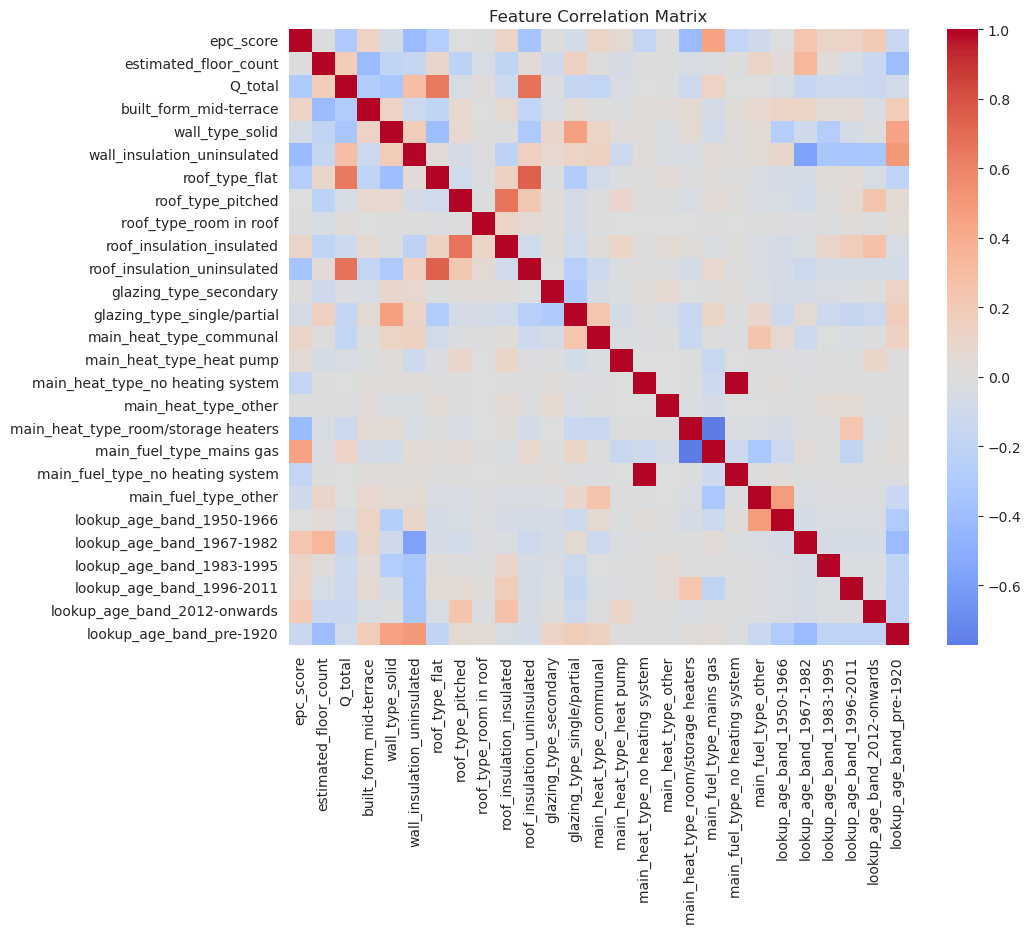

In [20]:
import numpy as np
corr_matrix = pd.DataFrame(X_train, columns=X.columns).corr()
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

# ML Model

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

              Model    R2     RMSE      MAE   MAPE  Acc(<10%)  Acc(<20%)
4  GradientBoosting 0.942 2027.940  763.963  8.898     74.238     88.854
0  LinearRegression 0.907 2554.912 1531.317 19.126     56.677     78.023
1             Ridge 0.907 2558.234 1529.474 19.074     56.467     78.233
2      DecisionTree 0.898 2688.565 1017.803 12.656     66.667     83.912
3      RandomForest 0.891 2778.652 1167.927 14.802     61.304     78.128
5        KNeighbors 0.849 3269.439 1475.462 18.316     60.778     73.922


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/tmp/ipykernel_62485/1618681004.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results_df, palette='coolwarm')


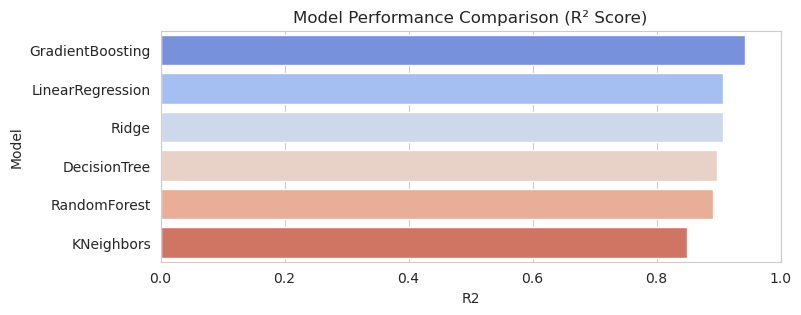

In [24]:


# 机器学习模型对比
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'DecisionTree': DecisionTreeRegressor(random_state=100, max_depth=10),
    'RandomForest': RandomForestRegressor(random_state=100, n_estimators=100, max_depth=7),
    'GradientBoosting': GradientBoostingRegressor(random_state=100, n_estimators=100, max_depth=6),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    # 新增MAPE，防止分母为0通常加一点小量,或者直接用np.mean
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    
    # 统计在误差阈值10%、20%以内的“准确率”
    abs_pct_error = np.abs((y_test - y_pred) / (y_test + 1e-8))
    acc_10 = np.mean(abs_pct_error < 0.10) * 100   # 10%以内百分比
    acc_20 = np.mean(abs_pct_error < 0.20) * 100   # 20%以内百分比

    results.append({
        'Model': name, 
        'R2': r2, 
        'RMSE': rmse, 
        'MAE': mae, 
        'MAPE': mape,
        'Acc(<10%)': acc_10,   # 误差小于10%的样本占比
        'Acc(<20%)': acc_20    # 误差小于20%的样本占比
    })

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
# 显示所有关键指标，保留3位小数，百分数列也美化
with pd.option_context('display.float_format', '{:.3f}'.format):
    print(results_df)
    
# 绘制R2对比条形图
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
sns.barplot(x='R2', y='Model', data=results_df, palette='coolwarm')
plt.title("Model Performance Comparison (R² Score)")
plt.xlim(0, 1)
plt.show()

# Boost Model API

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
import joblib

# 训练模型
gb = GradientBoostingRegressor(random_state=100, n_estimators=100, max_depth=5)
gb.fit(X, y)

# 保存模型和特征名
joblib.dump(gb, 'gb_model.joblib')
joblib.dump(X.columns.tolist(), 'gb_features.joblib')

['gb_features.joblib']

## Vis

,Feature,Standardized Coefficient
0,Calculated Heat Loss (Q_total),8314.490
1,Main Fuel Type Other,8312.884
2,Main Fuel Type Mains Gas,6887.485
3,Roof Type Room In Roof,5297.896
4,Main Fuel Type No Heating System,5107.962
5,Main Heat Type No Heating System,5107.962
6,Wall (Uninsulated),-4183.660
7,Flat Roof,-4108.532
8,Lookup Age Band 1996-2011,3573.880
9,EPC Score,-3415.335


/tmp/ipykernel_62485/2978900564.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


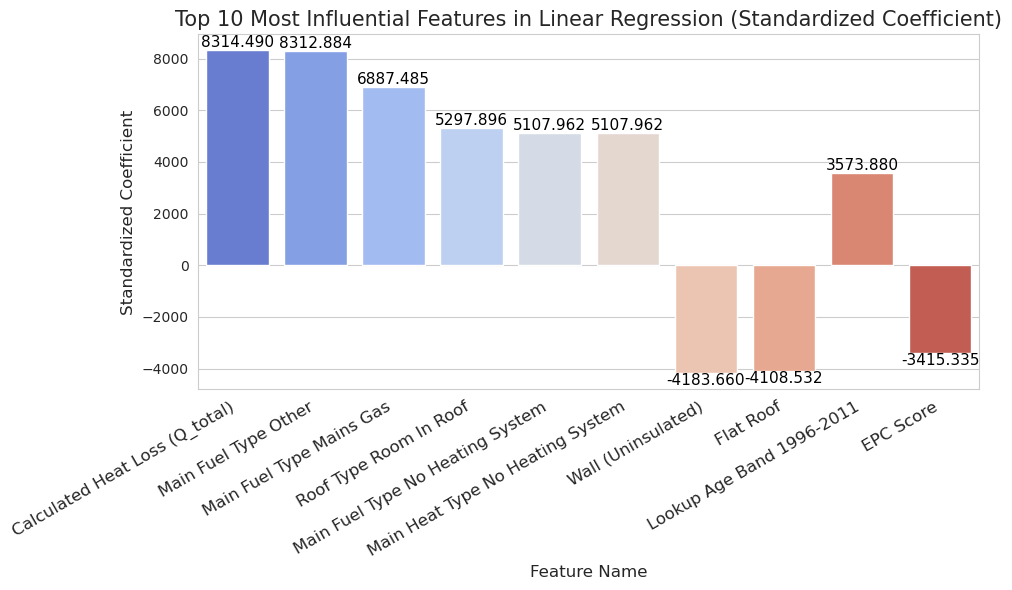

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 提取数值列和类别列
# 推荐标准化数值列，再和类别列concat
num_cols = ['epc_score', 'estimated_floor_count', 'Q_total']
cat_cols = [c for c in X_train.columns if c not in num_cols]

scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_train[num_cols])
X_all_train_scaled = np.concatenate([X_num_train_scaled, X_train[cat_cols].values], axis=1)

lr_scaled = LinearRegression()
lr_scaled.fit(X_all_train_scaled, y_train)

coefs = lr_scaled.coef_

# 合成变量名（保证顺序对齐）
all_feature_names = num_cols + cat_cols

coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefs
})

# ==== 保留三位小数 ====
coef_df['Coefficient'] = coef_df['Coefficient'].apply(lambda x: float(f"{x:.3f}"))

# 变量名映射（易读友好名）
readable_names = {
    'roof_insulation_uninsulated': "Roof (Uninsulated)",
    'roof_insulation_insulated': "Roof (Insulated)",
    'roof_type_flat': "Flat Roof",
    'roof_type_pitched': "Pitched Roof",
    'wall_insulation_uninsulated': "Wall (Uninsulated)",
    'main_fuel_type_no_heating_system': "No Main Fuel",
    'main_heat_type_no_heating_system': "No Heating System",
    'Q_total': "Calculated Heat Loss (Q_total)",
    'epc_score': "EPC Score",
    'main_fuel_type_mains_gas': "Mains Gas",
    # ...其余变量继续补...
}
coef_df['Feature Readable'] = coef_df['Feature'].map(lambda x: readable_names.get(x, x.replace("_", " ").title()))

# 按绝对值排序，取前10
coef_top10 = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(10).reset_index(drop=True)

# ==== 表格显示三位小数，无科学计数 ====
pd.set_option('display.float_format', '{:.3f}'.format)
display(
    coef_top10[['Feature Readable', 'Coefficient']].rename(
        columns={'Feature Readable': 'Feature', 'Coefficient': 'Standardized Coefficient'}
    )
)

# ==== 图形美化，三位小数，数字标注 ====
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = sns.barplot(
    data=coef_top10,
    x='Feature Readable',
    y='Coefficient',
    palette="coolwarm"
)
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.title("Top 10 Most Influential Features in Linear Regression (Standardized Coefficient)", fontsize=15)
plt.xlabel("Feature Name", fontsize=12)
plt.ylabel("Standardized Coefficient", fontsize=12)
for i, v in enumerate(coef_top10['Coefficient']):
    ax.text(i, v + 0.02 * (1 if v > 0 else -1), f"{v:.3f}", color='black', ha='center', va='bottom' if v > 0 else 'top', fontsize=11)
plt.tight_layout()
plt.show()